In [4]:
import argparse
import tensorflow as tf
import os
import numpy as np
from tensorflow.contrib import predictor
from models import input_fn
from models import CRNN as Model
from datahandler import DataHandler
from config import Config
import pickle
import traceback

def serving_input_receiver_fn():
    '''
    Serving input receiver function for tf.Estimator.export_savedmodel
    :return: a TensorServingInputReceiver fitting the input data specified in cf.hparams
    '''
    features = tf.placeholder(shape=[None, cf.hparams.n_epoch_samples, cf.hparams.n_channels], dtype=tf.float32)
    receiver_tensors = features
    return tf.estimator.export.TensorServingInputReceiver(features, receiver_tensors)

In [6]:
cf = Config('r-c-shhs',
            'cluster',
            'revised-shallow-noise',
            None).get_configs(cross_validate=7,
                                 matched=True)

DataHandler.setup_partitions(cf,
                             model_memory=True,
                             cross_validate=7)

Restoring partitions for: /scratch/users/rmth/tf_logs/r-c-shhs_cluster_revised-shallow-noise_cv/cv7/


In [ ]:
cf = Config('c-simulated',
            'cluster',
            'revised-shallow',
            None).get_configs(cross_validate=None)

DataHandler.setup_partitions(cf,
                             model_memory=True,
                             cross_validate=None)

In [ ]:
cf = Config('n2rem',
            'local',
            'revised-shallow-n2rem',
            None).get_configs(cross_validate=None)

DataHandler.setup_partitions(cf,
                             model_memory=True,
                             cross_validate=None)

In [ ]:
cf = Config('c-shhs',
            'cluster',
            'revised2-shallow',
            None).get_configs(cross_validate=4,
                                     matched=True)

DataHandler.setup_partitions(cf,
                             model_memory=True,
                             cross_validate=4)

In [7]:
exports = [int(e) for e in os.listdir(cf.eparams.ckptdir) if e.isdigit()]
export_dir = os.path.abspath(cf.eparams.ckptdir + str(exports[np.argmax(exports)]))
predict_fn = predictor.from_saved_model(export_dir)

INFO:tensorflow:Restoring parameters from /scratch/users/rmth/tf_logs/r-c-shhs_cluster_revised-shallow-noise_cv/cv7/1529328423/variables/variables


In [8]:
include_matched = True
do_td = True
trainIDs = DataHandler.partitions['train']
valIDs = DataHandler.partitions['val']
testIDs = DataHandler.partitions['test']
if include_matched:
    matchedIDs = DataHandler.partitions['matched']
train_probs = {}
train_group = {}
train_feat = {}
#train_sens = {}
val_probs = {}
val_group = {}
val_feat = {}
#val_sens = {}
test_probs = {}
test_group = {}
test_feat = {}
test_sens = {}
if include_matched:
    matched_probs = {}
    matched_group = {}
    matched_feat = {}
    matched_sens = {}
    total_records = len(trainIDs + valIDs + testIDs+ matchedIDs)
else:
    total_records = len(trainIDs + valIDs + testIDs)

In [9]:
ssc = False
def run_inference(id, partition, td = False):
    features, labels = input_fn(partition, cf.eparams, id)
    prob = []
    feat = []
    signal = []
    exp_sens = []
    con_sens = []
    while True:
        try:
            # this will break when input_fn can't make a full 16 times 5 min input
            # todo: use smaller batch, or zero pad for missing in batch
            x, y = sess.run([features, labels])
            predictions = predict_fn({"input": x})
            prob.append(np.transpose(predictions['probabilities'][:, 1]))
            feat.append(np.transpose(predictions['features']))
            if td:
                #print(x.shape)
                signal.append(x)
                exp_sens.append(predictions['experimental_sensitivity'])
                con_sens.append(predictions['control_sensitivity'])
        except:
            #print('{}: done processing {}'.format(partition, id))
            break
            
    features = np.reshape(np.transpose(np.asarray(feat), [0, 2, 1]), [len(feat)*4, -1])
    if not td:
        return np.argmax(y[0,:]), np.reshape(np.asarray(prob), [-1]), features
    else:
        #print(np.asarray(signal).shape)
        #signal = np.reshape( np.transpose(np.asarray(signal), [2, 4, 5, 0, 1, 3]), [2, 625, -1])
        arr = np.transpose(np.asarray(con_sens), [2, 4, 5, 0, 1, 3])
        n_channels = arr.shape[0]
        n_samples = arr.shape[2]
        td_con = np.reshape( arr, [n_channels, n_samples, -1])
        td_exp = np.reshape( np.transpose(np.asarray(exp_sens), [2, 4, 5, 0, 1, 3]), [n_channels, n_samples, -1])
        taylor_decomp = np.stack([td_con, td_exp], axis=3)
        return np.argmax(y[0,:]), np.reshape(np.asarray(prob), [-1]), features, taylor_decomp

In [10]:
with tf.Session() as sess:
    '''
    for step, id in enumerate(trainIDs):
        try:
            train_group[id], train_probs[id], train_feat[id] = run_inference(id, 'train_id')
            print('{}: done processing {} ({} of {})'.format('train_id', id, step+1, len(trainIDs)))
        except Exception as e:
            print(e)
            print(traceback.format_exc())
            print('{}: error processing {}'.format('train_id', id))
    print('Done processing {} of a total of {}'.format(len(trainIDs), total_records))
    for step,id in enumerate(valIDs):
        try:
            val_group[id], val_probs[id], val_feat[id] = run_inference(id, 'val_id')
            print('{}: done processing {} ({} of {})'.format('val_id', id, step+1, len(valIDs)))
        except Exception as e:
            print(e)
            print(traceback.format_exc())
            print('{}: error processing {}'.format('val_id', id))
    print('Done processing {} of a total of {}'.format(len(trainIDs+valIDs), total_records))
    '''        
    for step,id in enumerate(testIDs):
        try:
            test_group[id], test_probs[id], test_feat[id], test_sens[id] = run_inference(id, 'test_id', td=do_td)
            print('{}: done processing {} ({} of {})'.format('test_id', id, step+1, len(testIDs)))
        except Exception as e:
            print(e)
            print(traceback.format_exc())
            print('{}: error processing {}'.format('test_id', id))
    print('Done processing {} of a total of {}'.format(len(trainIDs+valIDs+testIDs), total_records))
    '''
    for step,id in enumerate(matchedIDs):
        try:
            matched_group[id], matched_probs[id], matched_feat[id], matched_feat[id] = run_inference(id, 'matched_id', td=do_td)
            print('{}: done processing {} ({} of {})'.format('matched_id', id, step+1, len(matchedIDs)))
        except Exception as e:
            print(e)
            print(traceback.format_exc())
            print('{}: error processing {}'.format('matched_id', id))
    '''


test_id: done processing shhs1-204185 (1 of 90)
test_id: done processing shhs1-202028 (2 of 90)
test_id: done processing shhs1-205385 (3 of 90)
test_id: done processing shhs1-200429 (4 of 90)
test_id: done processing shhs1-202793 (5 of 90)
test_id: done processing shhs1-202621 (6 of 90)
test_id: done processing shhs1-200545 (7 of 90)
test_id: done processing shhs1-204675 (8 of 90)
test_id: done processing shhs1-203478 (9 of 90)
test_id: done processing shhs1-201751 (10 of 90)
test_id: done processing shhs1-204381 (11 of 90)
test_id: done processing shhs1-203760 (12 of 90)
test_id: done processing shhs1-202807 (13 of 90)
test_id: done processing shhs1-202073 (14 of 90)
test_id: done processing shhs1-203117 (15 of 90)
test_id: done processing shhs1-204043 (16 of 90)
test_id: done processing shhs1-200181 (17 of 90)
test_id: done processing shhs1-204812 (18 of 90)
test_id: done processing shhs1-204128 (19 of 90)
test_id: done processing shhs1-205425 (20 of 90)
test_id: done processing shhs

In [14]:
'''
print('Exporting probabilities to: {}'.format(cf.eparams.ckptdir + 'eval/probabilities.pkl'))
with open(cf.eparams.ckptdir + 'eval/probabilities.pkl', 'wb') as f:
    pickle.dump([train_group, train_probs, val_group, val_probs, test_group, test_probs, matched_probs, matched_group], f)

print('Exporting features to: {}'.format(cf.eparams.ckptdir + 'eval/features.pkl'))
with open(cf.eparams.ckptdir + 'eval/features.pkl', 'wb') as f:
    pickle.dump(
        [train_group, train_feat, val_group, val_feat, test_group, test_feat, matched_feat, matched_group],
        f)
'''
print('Exporting taylor decompositions to: {}'.format(cf.eparams.ckptdir + 'eval/taylor_decompositions.pkl'))
with open(cf.eparams.ckptdir + 'eval/taylor_decompositions.pkl', 'wb') as f:
    pickle.dump(
        [test_sens, test_group, matched_sens, matched_group], f)
'''
print('Exporting taylor decompositions to: {}'.format(cf.eparams.ckptdir + 'eval/taylor_decompositions.pkl'))
with open(cf.eparams.ckptdir + 'eval/taylor_decompositions.pkl', 'wb') as f:
        pickle.dump([test_sens, test_group], f)
'''        
print('Done processing all.')

Exporting taylor decompositions to: /scratch/users/rmth/tf_logs/r-c-shhs_cluster_revised-shallow-noise_cv/cv7/eval/taylor_decompositions.pkl
Done processing all.


In [15]:
from scipy.ndimage.filters import gaussian_filter as gf
from scipy.signal import find_peaks_cwt
from sklearn.manifold import TSNE
from scipy.signal import welch
import h5py
from sklearn.model_selection import KFold
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.decomposition import PCA

In [16]:
simulated = False
revised = False
n2rem = False

if simulated or revised or n2rem:
    with open(cf.eparams.ckptdir + 'eval/taylor_decompositions.pkl', 'rb') as f:
        test_sens, test_group = pickle.load(f)
else:
    with open(cf.eparams.ckptdir + 'eval/taylor_decompositions.pkl', 'rb') as f:
        test_sens, test_group, matched_sens, matched_group = pickle.load(f)
        
sns.set()
if simulated:
    data_folder = '/scratch/users/rmth/simulated_data/'
elif n2rem:
    data_folder = '/home/rasmus/Desktop/SSC/processed_data/'
elif revised:
    data_folder = '/scratch/users/rmth/processed_shhs_data_revised/'
else:
    data_folder = '/scratch/users/rmth/processed_shhs_data/'
n_samples_subepoch = 625

In [17]:
def evidence_difference(td, group):
    pos = copy.deepcopy(td)
    pos[pos < 0] = 0
    #neg = copy.deepcopy(td)
    #neg[neg > 0] = 0
    #neg_evidence = np.abs(np.sum(neg))
    pos_evidence = np.trapz(pos)
    #evidence_diff = pos_evidenc - neg_evidence
    #evidence_diff = np.trapz(td)
    evidence_diff = pos_evidence# np.trapz(td)
    if group:
        return evidence_diff
    else:
        return -evidence_diff
    #return evidence_diff

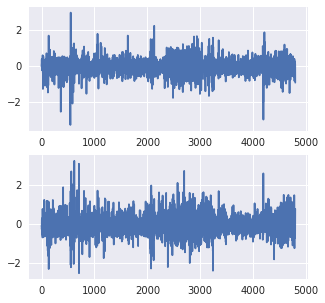

In [18]:
for pred, id in enumerate(test_sens):
    #print(int((pred+1)/len(test_sens)*100.0))
    if pred != 0:
        continue
    path = data_folder + id + '.hpf5'
    with h5py.File(path, "r") as f:
        dset = np.array(f["x"])
        data = np.squeeze(dset[:, :, :])
        n_channels = data.shape[0]
        n_epochs = data.shape[1]
        n_samples = test_sens[id].shape[1] 
        data = np.reshape(data, [n_channels, n_epochs, -1 , n_samples])
        data = np.reshape(data, [n_channels, -1, n_samples])
        data = np.transpose(data, [0, 2, 1])
        data = data[:,:,:test_sens[id].shape[2]]
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (5,5))
    ax[0].plot(data[0,6,:])
    #ax[0].set_xlim([0,1000])
    ax[1].plot(data[1,7,:])
    #ax[1].set_xlim([0,1000])
    
    
plt.show()

In [23]:
if simulated:
    grp_names = ['Sine', 'Saw-tooth']
elif n2rem:
    grp_names = ['REM', 'N2']
else:
    grp_names = ['Non-stroke', 'Stroke']

if n2rem:
    chn_names = ['C3', 'C4', 'Fz', 'ROC', 'LOC', 'Chin']
else:
    chn_names = ['C3', 'C4']

if n2rem:
    fs = 128.0
else:
    fs = 125.0
    
do_plotting = False

pct_val = 95
std_multi = 7
smoothening = 10
std_peaks = []
std_evidence = []
std_spec = []
std_id = []
for pred, id in enumerate(test_sens):
    #if pred != 0:
    #    continue
    print(pred)
    #print(int((pred+1)/len(test_sens)*100.0))
    #if pred == 0 or pred == 50:
    #    print('lol')
    #else: 
    #    continue
    path = data_folder + id + '.hpf5'
    with h5py.File(path, "r") as f:
            
            dset = np.array(f["x"])
            data = np.squeeze(dset[:, :, :])
            n_channels = data.shape[0]
            n_epochs = data.shape[1]
            n_samples = test_sens[id].shape[1] 
            data = np.reshape(data, [n_channels, n_epochs, -1 , n_samples])
            data = np.reshape(data, [n_channels, -1, n_samples])
            data = np.transpose(data, [0, 2, 1])
            data = data[:,:,:test_sens[id].shape[2]]
            '''
            dset = np.array(f["x"])
            data = np.squeeze(dset[:, :, :])
            data = np.transpose(data, [0, 1, 2])
            data = np.reshape(data, [2, data.shape[1], -1, n_samples_subepoch])
            data = np.reshape(data, [2, -1, 625])
            data = np.transpose(data, [0, 2, 1])
            data = data[:,:,:test_sens[id].shape[2]]
            '''
            #print(data.shape)
            #data = data[:,:,:test_sens[id].shape[2]]
            #print(data.shape)
    sens = test_sens[id]
    grp = test_group[id]
    #print('data.shape: {}'.format(data.shape))
    #print('sens.shape: {}'.format(sens.shape))
    #print(data.shape) # (2, 625, 5760)
    #print(sens.shape) # (2, 625, 5760, 2)
    print('Group: {}'.format(grp_names[grp]))
    if do_plotting:
        idx = 501
        fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
        yl = 0.2
        yld = 7
        t = np.arange(0, int(data.shape[1]//fs), 1/fs)
        for channel in range(2):
            ax[0, channel].plot(t,data[channel, :, idx],'k')
            ax[0, channel].set_ylim([-yld, yld])
            ax[0, channel].set_title(chn_names[channel])
        for group in range(2):
            for channel in range(2):
                x = gf(sens[channel, :, idx, group], smoothening)
                ax[group+1, channel].plot(t,x)
                ax[group+1, channel].set_ylim([-yl, yl])
                ax[group+1, channel].set_title(r'$\theta(t)$ ({}, {})'.format(chn_names[channel], grp_names[group]))
        plt.show()
    
    n_chans = sens.shape[0]
    n_subepochs = sens.shape[2]
    n_classes = sens.shape[3]
    evi_diff = np.empty([n_chans, n_subepochs, n_classes])
    for chan in range(n_chans):
        for subepoch in range(n_subepochs):
            for group in range(n_classes):
                #x = sens[chan, :, subepoch, group]
                x = gf(sens[chan, :, subepoch, group], smoothening)
                evi_diff[chan, subepoch, group] = evidence_difference(x, group)
    
    idx = np.unravel_index(np.argmax(np.abs(evi_diff)), evi_diff.shape)
    print(idx)
    idx = idx[1]
    if do_plotting:
        fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(13,20))
        print('Group: {}'.format(grp_names[grp]))
        for channel in range(2):
            ax[0, channel].plot(t,data[channel, :, idx],'k')
            ax[0, channel].set_xlabel('Time [s]', fontsize=15)
            ax[0, channel].set_ylabel('Amplitude [V]', fontsize=15)
            ax[0, channel].autoscale(enable=True, axis='x', tight=True)
            #x = data[channel, :, idx]
            #y = sens[channel, :, idx, 1]
            #t = np.arange(0, 5, 1/fs)
            #ax[0, channel].scatter(t,x, 5, y,cmap='seismic', vmin=-0.05, vmax=0.05)
            ax[0, channel].set_ylim([-yld, yld])
            ax[0, channel].set_title('EEG: {}'.format(chn_names[channel]), fontsize=17)
        for group in range(2):
            for channel in range(2):
                x = gf(sens[channel, :, idx, group], smoothening)
                ax[group+1, channel].plot(t,x)
                ax[group+1, channel].set_xlabel('Time [s]', fontsize=15)
                ax[group+1, channel].set_ylabel(r'$\theta(t)$', fontsize=15)
                ax[group+1, channel].set_ylim([-yl, yl])
                ax[group+1, channel].autoscale(enable=True, axis='x', tight=True)
                ax[group+1, channel].set_title('Taylor Decomposition: {}, {}'.format(chn_names[channel], grp_names[group]), fontsize=17)

        #print(evi_diff.shape) # (2, 5760, 2)

        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
        xl = 2
        for chn in range(2):
            for grp in range(2):
                ax[chn,grp].hist(evi_diff[chn,:,grp],bins=100)
                ax[chn,grp].set_title([chn_names[chn], grp_names[grp]])
                ax[chn,grp].set_xlim([-xl, xl])
                ax[chn,grp].set_xticks([-.5*xl, 0, .5*xl])
                ax[chn,grp].set_xticklabels(['More no', 0, 'More yes'])
                ax[chn,grp].set_ylim([0, 2500])

        plt.show()
        
    pct0 = np.std(np.abs(evi_diff[:,:,0]))*std_multi
    pct1 = np.std(np.abs(evi_diff[:,:,1]))*std_multi
    #print(pct0)
    #print(pct1)
    
    #pct0 = np.percentile(np.abs(evi_diff[:,:,0]), pct_val)
    #pct1 = np.percentile(np.abs(evi_diff[:,:,1]), pct_val)
    #print(pct0)
    
    above_pct0 = np.abs(evi_diff[:,:,0]) > pct0
    above_pct1 = np.abs(evi_diff[:,:,1]) > pct1
    #print(evi_diff.shape) # (2, 5760, 2), (channel, subepoch, class)
    #print(data.shape) # (2,625,5760), (channel, sample, subepoch)
    #print(test.shape) # (2,5760,2) (channel, subepoch, class)
    for subepoch in range(n_subepochs):
        cond0 = (sum(above_pct0[:,subepoch])) != 0
        cond1 = (sum(above_pct1[:,subepoch])) != 0
        if cond0 or cond1:
            if n2rem:
                peak = data[:,:,subepoch]
            else:
                peak = data[:,:,subepoch-1:subepoch+2]
                if peak.shape != (2,625,3):
                    print('Window at end of segment. Ignoring.')
                    continue
                peak = np.transpose(peak,[0,2,1])
                peak = np.reshape(peak, [2, -1])
            evidence = evi_diff[:,subepoch,:]
            f,Pxx = welch(peak, fs = fs, nperseg = 3*fs, nfft = 512)
            Pxx = 10*np.log10(Pxx)
            Pxx = Pxx # np.sum(Pxx)
          
            std_evidence.append(evidence)
            std_peaks.append(peak)
            std_spec.append(Pxx)
            std_id.append(id)
            

0
Group: Non-stroke
(1, 546, 1)
1
Group: Non-stroke
(1, 5756, 1)
2
Group: Non-stroke
(0, 4783, 1)
3
Group: Non-stroke
(0, 3782, 1)
4
Group: Non-stroke
(0, 6, 1)
5
Group: Non-stroke
(1, 1644, 1)
6
Group: Stroke
(0, 1262, 1)
7
Group: Non-stroke
(0, 3848, 1)
8
Group: Non-stroke
(1, 886, 1)
9
Group: Non-stroke
(0, 1200, 1)
10
Group: Non-stroke
(1, 2217, 0)
11
Group: Non-stroke
(1, 5457, 0)
12
Group: Non-stroke
(0, 1797, 1)
13
Group: Non-stroke
(0, 426, 1)
14
Group: Stroke
(1, 1080, 1)
15
Group: Non-stroke
(1, 5027, 0)
16
Group: Stroke
(1, 5007, 0)
17
Group: Non-stroke
(1, 24, 1)
18
Group: Non-stroke
(1, 1441, 1)
19
Group: Non-stroke
(1, 2824, 0)
20
Group: Non-stroke
(1, 1147, 1)
21
Group: Non-stroke
(1, 1017, 0)
22
Group: Non-stroke
(1, 246, 1)
23
Group: Stroke
(1, 57, 0)
Window at end of segment. Ignoring.
24
Group: Non-stroke
(0, 4383, 1)
25
Group: Non-stroke
(1, 3351, 0)
26
Group: Non-stroke
(0, 181, 1)
27
Group: Non-stroke
(0, 3368, 0)
28
Group: Non-stroke
(0, 4909, 0)
29
Group: Non-st

In [24]:
peaks = np.asarray(std_peaks)
ids = np.asarray(std_id)
specs = np.square(np.asarray(std_spec))
evidence = np.asarray(std_evidence)
specs = np.reshape(specs, [-1, n_channels*257])

In [25]:
print(specs.shape)

(1427, 514)


In [78]:
#pca = PCA(n_components=10)
#red = pca.fit_transform(specs)

tsne = TSNE(n_components=2, n_iter = 10000, perplexity=10)
red = tsne.fit_transform(specs)

<IPython.core.display.Javascript object>


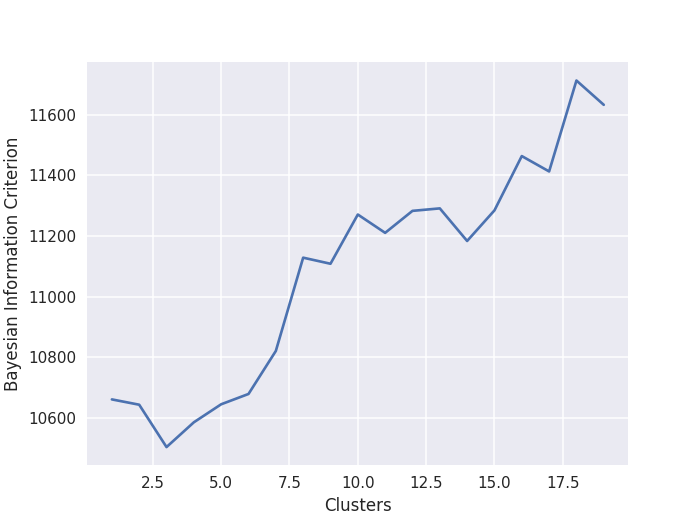

In [79]:
kf = KFold(n_splits=3)
llh = []
Ks = np.arange(1, 20, 1)
for k in Ks:# range(K):
    llh_splits = []
    for train, test in kf.split(red):
        gm = GaussianMixture(n_components=k, n_init=3, covariance_type = 'spherical', reg_covar = 1e-2)
        gm.fit(red[train,:])
        llh_splits.append(gm.bic(red[test,:]))
    llh.append(np.mean(llh_splits))
fig,ax = plt.subplots(nrows=1,ncols=1)
ax.plot(Ks, llh)
ax.set_xlabel('Clusters')
ax.set_ylabel('Bayesian Information Criterion')
plt.show()
#gm = GaussianMixture(n_components=np.argmin(llh)+1, n_init = 3)
#gm = GaussianMixture(n_components=50, n_init = 3)
#gm.fit(red)
#grp = gm.predict(red)

In [110]:
K = Ks[np.argmin(llh)]
print(K)
K = 20
gm = GaussianMixture(n_components=K, n_init = 3)
gm.fit(red)
grp = gm.predict(red)

3


In [111]:
v = np.max(evidence) 
print(evidence.shape)
normalized_evidence = np.empty(shape=evidence.shape)
for cls in range(2):
    for chn in range(n_channels):
        x = evidence[:,chan,cls]
        #plt.subplot(2,2,cls+1)
        #plt.plot(x)
        #plt.ylim([0,1])
        #norm = np.std(x)+1e-12
        norm = np.percentile(np.abs(x),50) + 1e-15
        normalized_evidence[:,chan,cls] = x/norm
        #plt.subplot(2,2,2+cls+1)
        #plt.plot(x/norm)
        #plt.ylim([-1,0])
        #print(np.min(x/norm))
#plt.show()
total_evidence = np.mean(np.mean(evidence, axis = 1), axis = 1)
total_evidence_normalized = np.mean(np.mean(normalized_evidence, axis=1),axis=1)
evi = total_evidence 

grp_evidence = []
for k in range(K):
    if sum(grp == k) == 0:
        grp_evidence.append(np.nan)
    else:
        grp_evidence.append(np.mean(evi[grp == k]))
    
n_clusters = 2
n_cl = n_clusters//2
cluster_names = []
for j in range(2):
    for i in range(n_cl):
        cluster_names.append(grp_names[j])
        
n_cluster_examples = 5

restart = True
step = 0
while restart:
    step += 1
    if step == 4: break
    sorted_group = [x for _,x in sorted(zip(grp_evidence,np.arange(0,K)))]
    grp_indices = sorted_group[:n_cl] + sorted_group[-n_cl:]
    restart = False
    for k in range(len(grp_indices)):
        cluster_peaks = peaks[grp == grp_indices[k],:,:]
        cluster_ids = ids[grp == grp_indices[k]]
        if len(np.unique(cluster_ids)) < 5:
            #grp_evidence[grp_indices[k]] = 0
            grp_evidence[grp_indices[k]] = np.median(grp_evidence)
            restart = True

(1427, 2, 2)


<IPython.core.display.Javascript object>


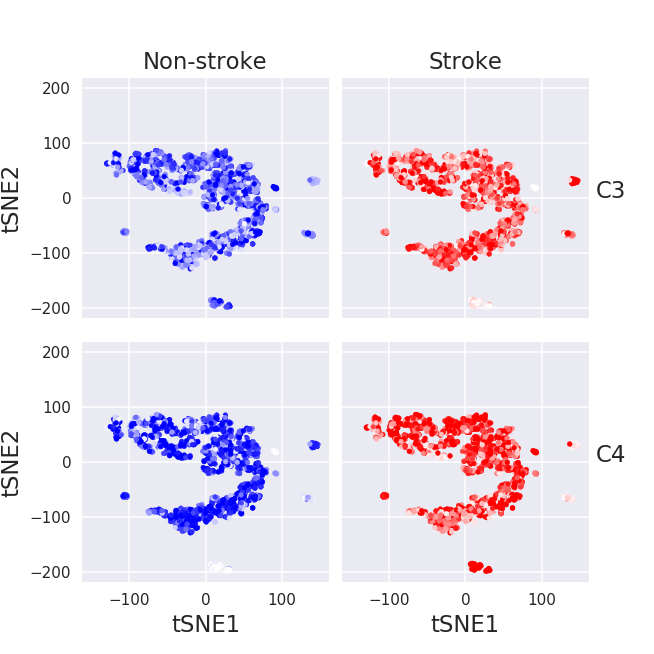

<IPython.core.display.Javascript object>


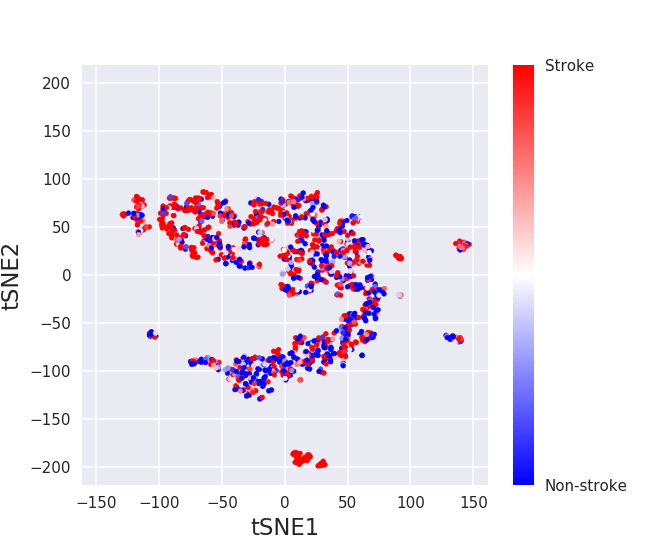

In [112]:
#v = np.max(evidence)*.75
v = np.percentile(np.abs(evidence), 75)
pcxlim = 1.1*np.max(np.abs(red[:,0]))
pcylim = 1.1*np.max(np.abs(red[:,1]))
if n2rem:
    fig, ax = plt.subplots(ncols=2, nrows=n_channels, figsize=(6,18))
else:
    fix, ax = plt.subplots(ncols=2, nrows=n_channels, figsize=(6,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=.05, hspace=.1)

for chan in range(n_channels):
    for cls in range(2):
        im = ax[chan, cls].scatter(red[:,0],red[:,1],s=10, c=evidence[:,chan,cls], vmin=-v, vmax=v, cmap='bwr')
        #ax[chan,cls].set_title(chn_names[chan] + grp_names[cls])

        if cls == 1:
            ax[chan,cls].text(1.05*pcxlim,0, chn_names[chan], fontsize=15)
        if chan == 0:
            ax[chan,cls].set_title(grp_names[cls], fontsize=15)
        
        if chan == n_channels-1:
            ax[chan,cls].set_xlabel('tSNE1', fontsize=15)
        else:
            ax[chan,cls].set_xticklabels([])
        

        if cls == 0:
            ax[chan,cls].set_ylabel('tSNE2', fontsize=15)
        else:
            ax[chan,cls].set_yticklabels([])
            
        ax[chan,cls].set_xlim([-pcxlim, pcxlim])
        ax[chan,cls].set_ylim([-pcylim, pcylim])
plt.show()

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,5))
evi = total_evidence#_normalized
#v = np.max(np.abs(evi))*.5 #0.05#1e-8# 5e-6
v = np.percentile(np.abs(evi),25) #0.05#1e-8# 5e-6
im = ax.scatter(red[:,0],red[:,1], c=evi,s=10,vmin=-v, vmax=v, cmap='bwr')

cb = fig.colorbar(im,ax=ax)
cb.set_ticks([-v,v])
cb.set_ticklabels([grp_names[0], grp_names[1]])
ax.set_xlabel('tSNE1', fontsize=15)
ax.set_ylabel('tSNE2', fontsize=15)
ax.set_xlim([-pcxlim, pcxlim])
ax.set_ylim([-pcylim, pcylim])
plt.show()


<IPython.core.display.Javascript object>


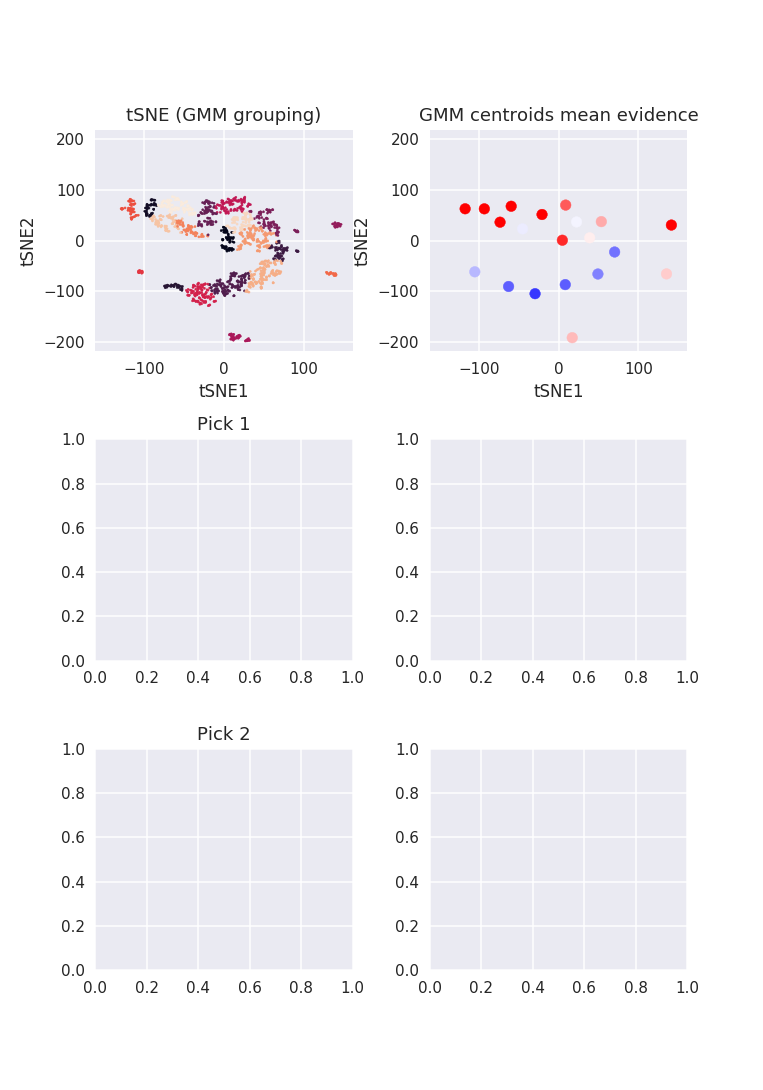

In [113]:
%matplotlib notebook

pcxlim = 1.1*np.max(np.abs(red[:,0]))
pcylim = 1.1*np.max(np.abs(red[:,1]))
if n2rem:
    t = np.arange(0,n_samples//fs, 1/fs)
else:
    t = np.arange(0,3*n_samples//fs,1/fs)
f, axarr = plt.subplots(3, 2, sharex=False, squeeze=False, figsize=(7,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=.3, hspace=.4)
axarr[0,0].scatter(red[:,0],red[:,1], c=grp, s=2, picker=True)
axarr[0,0].set_title('tSNE (GMM grouping)')
axarr[0,1].set_title('GMM centroids mean evidence')
for i in range(3):
    for j in range(2):
        axarr[i,j].spines['top'].set_visible(False)
        axarr[i,j].spines['right'].set_visible(False)
axarr[1,0].set_title('Pick 1')
axarr[2,0].set_title('Pick 2')

axarr[0,0].set_xlabel('tSNE1')
axarr[0,1].set_xlabel('tSNE1')
axarr[0,0].set_ylabel('tSNE2')
axarr[0,1].set_ylabel('tSNE2')
axarr[0,1].scatter(gm.means_[:,0],gm.means_[:,1],
                   c=grp_evidence, vmin=-v, vmax=v,
                   picker=True, cmap='bwr')
for i in range(2):
    axarr[0,i].set_xlim([-pcxlim, pcxlim])
    axarr[0,i].set_ylim([-pcylim, pcylim])
pick_text = [None,None]
pick_circle = [None, None]
sep = 2
if simulated:
    sep = 9
    circle_size = 4
    lower_yl = -9
    yl = 6+sep
else:
    sep = 4
    circle_size = 10
    lower_yl = -4
    yl = n_channels*sep
lw = 0.5
def onpick(e):
    axes = e.canvas.figure.axes
    ind = e.ind
    if e.mouseevent.inaxes == axes[0]:
        if len(ind) != 1:
            ind = ind[0]
        ax = 2 if e.mouseevent.button == 1 else 4
        axes[ax].clear()
        for chan in range(n_channels):
            axes[ax].plot(t,np.squeeze(peaks[ind,chan,:])+chan*sep, linewidth=lw)
        axes[ax].autoscale(enable=True, axis='x', tight=True)
        axes[ax].set_ylim([lower_yl,yl])
        axes[ax].set_ylabel('EEG  [softmax normalized]')
        axes[ax].set_xlabel('Time [s]')
        axes[ax].set_yticks(np.arange(0, n_channels*sep, sep))
        axes[ax].set_yticklabels(chn_names)
        axes[ax].set_title('Pick {} ({})'.format(str(ax//2),ids[ind]) )# + ', index: ' + str(ind) + ', group: ' + str(grp[ind]))# + ', prob: ' + str(np.max(prop[ind])) )
        if pick_text[ax//2-1] != None: pick_text[ax//2-1].remove()
        if pick_circle[ax//2-1] != None: pick_circle[ax//2-1].remove()
        
        pick_circle[ax//2-1] = plt.Circle( (red[ind,0],red[ind,1]), circle_size, 
                                          facecolor='none', edgecolor='r',
                                         linewidth=1)
        axes[0].add_patch( pick_circle[ax//2-1] )

        pick_text[ax//2-1] = axes[0].text(red[ind,0],red[ind,1],str(ax//2), color='r', fontsize=16)

        
        axes[ax+1].clear()
        for chan in range(n_channels):
            f,Pxx = welch(np.squeeze(peaks[ind,chan,:]), fs = fs, nfft = 500)
            Pxx = 10*np.log10(Pxx)
            axes[ax+1].plot(f,Pxx, linewidth=lw)
        
        #axes[ax+1].set_xticks([1, 5, 10, 20])
        #axes[ax+1].set_xticklabels(['1','5','10','20'])
        axes[ax+1].set_xticks([1, 5, 10, 20, 30, 40, 50, 60])
        axes[ax+1].set_xlabel('Frequenzy [Hz]')
        axes[ax+1].set_ylabel('Power [dB]')
        #axes[ax+1].set_xlim([0,30])
        axes[ax+1].set_xlim([0,35])
        axes[ax+1].set_ylim([-60,10])
    elif e.mouseevent.inaxes == axes[1]:
        size = np.ones(grp.shape)*8
        size[grp == ind] = 20 if e.mouseevent.button == 1 else 8
        axes[0].collections[0].set_sizes(size)

cid = f.canvas.mpl_connect('pick_event', onpick)
#f.suptitle('STD Peak Clustering\n\n\n')
#plt.iplot()
plt.show()

<IPython.core.display.Javascript object>


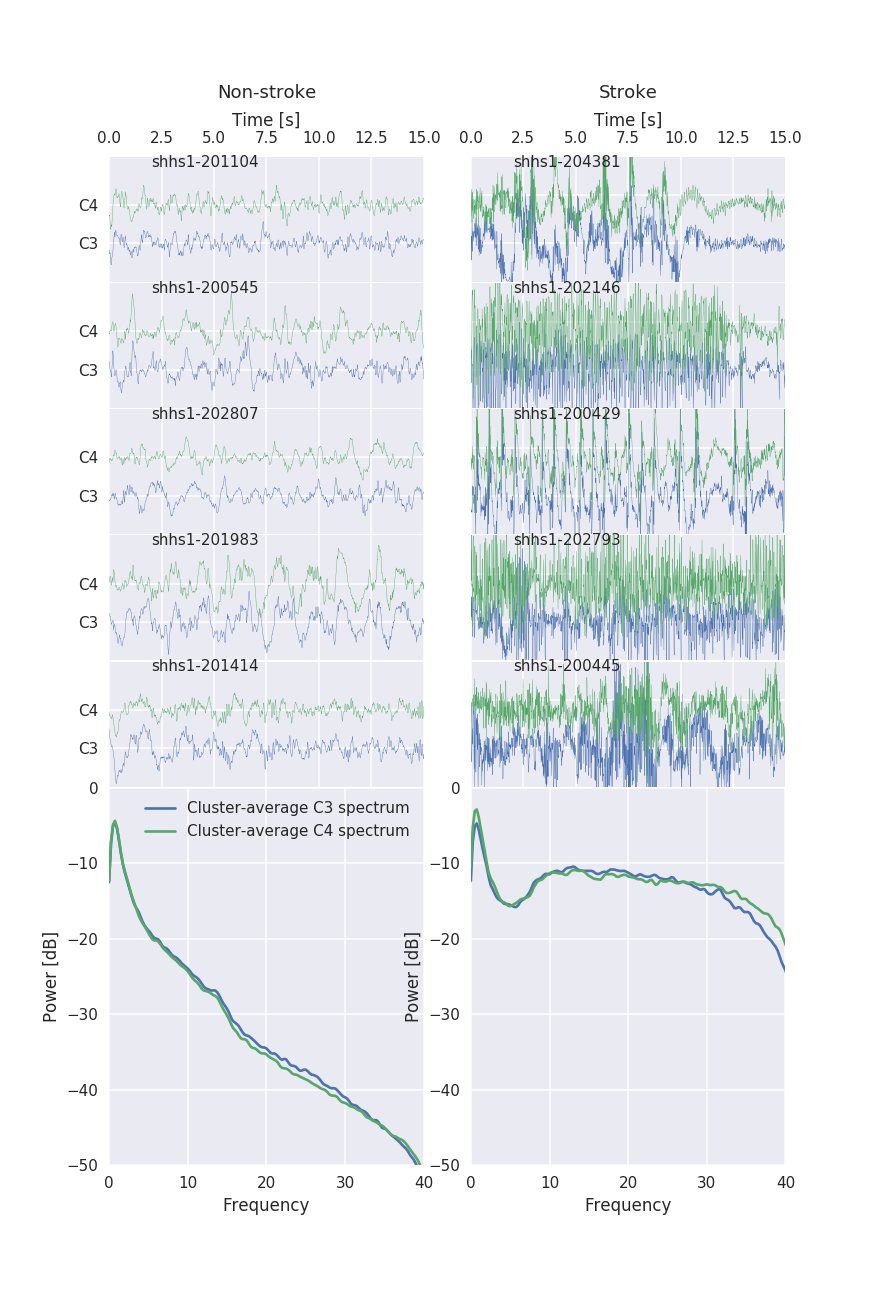

0
too many
1
too many


In [119]:
fig, ax = plt.subplots(nrows=n_cluster_examples+3, ncols=n_clusters, figsize=(8,12))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=.15, hspace=.01)
if simulated:
    sep = 9
else:
    sep = 4
lw = .25
axes = []
for k in range(len(grp_indices)):
    cluster_peaks = peaks[grp == grp_indices[k],:,:]
    cluster_ids = ids[grp == grp_indices[k]]
    f,Pxx = welch(cluster_peaks, fs = fs, nfft = 500)
    Pxx = 10*np.log10(Pxx)
    meanPxx = np.mean(Pxx, axis=0)
    #print(cluster_peaks.shape)
    #print(Pxx.shape)
    #print(meanPxx.shape)
    n_cluster_unique = np.unique(cluster_ids)
    
    d = {}
    for index, value in enumerate(cluster_ids):
        if value not in d:
            d[value] = index
    indices = [v for key,v in d.items()]
    print(k)
    if len(indices) != n_cluster_examples:
        if len(indices) < n_cluster_examples:
            print('too few')
            randoms = np.random.permutation(np.arange(cluster_peaks.shape[0]))
            for j in range(n_cluster_examples-len(indices)):
                indices.append(randoms[j])
        else:
            print('too many')
            indices = np.random.permutation(indices)
            indices = indices[:n_cluster_examples]
    indices = [int(e) for e in indices]
    
    for n in range(n_cluster_examples):
        x = cluster_peaks[indices[n],:,:]
        if simulated:
            ax[n,k].text(1.975*n_samples//fs,n_channels*sep*0.85, cluster_ids[indices[n]])
        else:
            ax[n,k].text(0.55*n_samples//fs,n_channels*sep, cluster_ids[indices[n]])
        #print(x.shape)
        for chan in range(n_channels):
            ax[n,k].plot(t,x[chan,:]+chan*sep, linewidth=lw)
        if n == 0: ax[n,k].set_title(cluster_names[k], y = 1.4)
        if n != 0:#n_cluster_examples-1: 
            ax[n,k].set_xticklabels([])
        else:
            ax[n,k].xaxis.tick_top()
            ax[n,k].set_xlabel('Time [s]')
            ax[n,k].xaxis.set_label_position('top') 
        if k != 0: 
            ax[n,k].set_yticklabels([])
        else:
            ax[n,k].set_yticks(np.arange(0, n_channels*sep, sep))
            ax[n,k].set_yticklabels(chn_names)
        ax[n,k].autoscale(enable=True, axis='x', tight=True)
        if simulated:
            ax[n,k].set_ylim([-sep,2*sep])
        else:
            ax[n,k].set_ylim([-4,n_channels*sep+1])
    axes.append(plt.subplot2grid((n_cluster_examples+3, n_clusters), (n_cluster_examples, k), rowspan=3))
    pxx_handles = []
    for chan in range(n_channels):
        h, = axes[-1].plot(f, meanPxx[chan,:], label='Cluster-average {} spectrum'.format(chn_names[chan]))
        pxx_handles.append(h)
    
    #c3, = axes[-1].plot(f, meanPxx[0,:], label='Cluster-average C3 spectrum')
    #c4, = axes[-1].plot(f, meanPxx[1,:], label='Cluster-average C4 spectrum')
    
    if k == 0:
        axes[-1].legend(handles=pxx_handles)
    axes[-1].set_xlim([0,40])
    axes[-1].set_ylim([-50,0])
    axes[-1].set_xlabel('Frequency')
    axes[-1].set_ylabel('Power [dB]')
    #plt.subplot(n)
    #ax[n:n+3,k].plot([0,0], [0,0])

plt.show()
